In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Evaluation
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Read in csv and Inspect Data

In [2]:
# Load the dataset
df = pd.read_csv("../Resources/st_paul_sold_properties.csv")
df.head()

,list_date,list_price,sold_date,sold_price,beds,baths,sqft,lot_sqft,city,street,zip,latitude,longitude
0,1/31/2025,209900.0,3/31/2025,209900,2.0,1.5,904.0,4704.0,Saint Paul,868 Algonquin Ave,55119,44.967562,-93.017718
1,11/15/2024,374900.0,12/13/2024,391000,3.0,1.5,1534.0,4966.0,Saint Paul,1246 Bayard Ave,55116,44.922167,-93.152861
2,12/20/2024,275000.0,1/10/2025,266800,3.0,1.0,1297.0,6534.0,Saint Paul,967 California Ave W,55117,44.991249,-93.140914
3,1/23/2025,500000.0,2/28/2025,505003,3.0,2.0,1636.0,5009.0,Saint Paul,2098 Pinehurst Ave,55116,44.918628,-93.189055
4,3/18/2025,425000.0,4/8/2025,475000,4.0,1.0,1750.0,7362.0,Saint Paul,2129 Sargent Ave,55105,44.935472,-93.190323


In [3]:
# Summary of Columns
df.info()

# Check for missing values
df.isnull().sum()

# Summary Statitics for numeric columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   list_date   999 non-null    object 
 1   list_price  999 non-null    float64
 2   sold_date   1300 non-null   object 
 3   sold_price  1300 non-null   int64  
 4   beds        1299 non-null   float64
 5   baths       1299 non-null   float64
 6   sqft        1299 non-null   float64
 7   lot_sqft    1296 non-null   float64
 8   city        1300 non-null   object 
 9   street      1300 non-null   object 
 10  zip         1300 non-null   int64  
 11  latitude    1300 non-null   float64
 12  longitude   1300 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 132.2+ KB


,list_price,sold_price,beds,baths,sqft,lot_sqft,zip,latitude,longitude
count,9.990000e+02,1.300000e+03,1299.000000,1299.000000,1299.000000,1296.000000,1300.000000,1300.000000,1300.000000
mean,3.846544e+05,3.652051e+05,3.270208,1.862972,1769.148576,8470.795525,55110.849231,44.966269,-93.103217
std,2.396307e+05,2.293069e+05,0.986877,0.901381,977.162038,11394.884100,7.250518,0.042874,0.061034
min,8.100000e+04,4.250000e+04,1.000000,1.000000,420.000000,479.000000,55102.000000,44.803497,-93.226536
25%,2.500000e+05,2.450000e+05,3.000000,1.000000,1260.000000,4966.000000,55105.000000,44.935223,-93.153954
50%,3.110000e+05,3.001500e+05,3.000000,2.000000,1580.000000,6098.000000,55107.000000,44.961697,-93.111839
75%,4.299000e+05,4.050000e+05,4.000000,2.000000,1994.000000,8913.500000,55117.000000,44.979586,-93.049063
max,2.420000e+06,2.423844e+06,9.000000,13.000000,15294.000000,263974.000000,55130.000000,45.127084,-92.986948


# Feature Engineering and Clean Data

In [4]:
# Convert date columns
df['list_date'] = pd.to_datetime(df['list_date'], errors='coerce')
df['sold_date'] = pd.to_datetime(df['sold_date'], errors='coerce')

# Calculate days_on_market
df['days_on_market'] = (df['sold_date'] - df['list_date']).dt.days

# Select features
features = ['baths', 'beds', 'lot_sqft', 'sqft', 'sold_price', 'days_on_market']
df_model = df[features].copy()

# Drop rows with missing target or feature values
df_model = df_model.dropna()


# Correlations and Heat Map

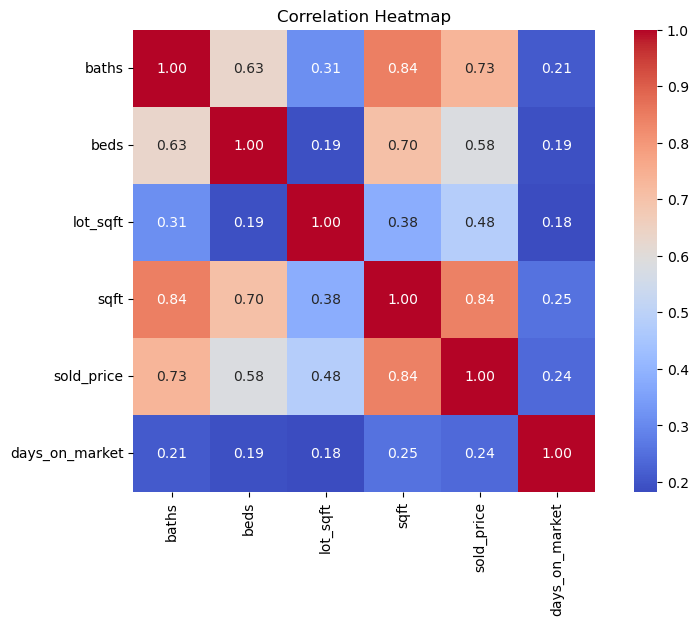

In [5]:
# Correlation matrix
corr = df_model.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

Sqft and baths also have a positive correlation with sold_price at 0.84 and 0.73.

# Regression to Predict sold_price and days_on_market

In [12]:
# Define all models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

In [13]:
# Funtion to Train and Evaluate
def evaluate_models(X, y, task_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results = {}
    best_model = None
    best_mae = float('inf') # lower MAE is better

    for name, model in models.items():
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MAE': mae, 'R2': r2}
        
        if mae < best_mae:
            best_mae = mae
            best_model = pipe
    
    print(f"\n {task_name} Results:")
    results_df = pd.DataFrame(results).T.sort_values(by='MAE')
    return results_df, best_model


In [14]:
X = df_model.drop(columns=['sold_price', 'days_on_market'])
results_price, best_price_model = evaluate_models(X, df_model['sold_price'], "Sold Price")
results_dom, best_dom_model = evaluate_models(X, df_model['days_on_market'], "Days on Market")

print("\n Sold Price Model Performance:")
display(results_price)

print("\n Days on Market Model Performance:")
display(results_dom)


 Sold Price Results:

 Days on Market Results:

 Sold Price Model Performance:


,MAE,R2
Random Forest,62227.030776,0.779129
Decision Tree,65256.910000,0.665185
Gradient Boosting,67464.467107,0.757986
KNN,77724.473000,0.658630
Ridge Regression,79717.602581,0.680255
Lasso Regression,79745.531561,0.680051
Linear Regression,79745.550766,0.680051
AdaBoost,84007.873809,0.643426



 Days on Market Model Performance:


,MAE,R2
Decision Tree,23.225000,0.080191
Random Forest,25.462033,0.170804
Lasso Regression,27.764351,0.098589
Ridge Regression,27.804259,0.097539
Linear Regression,27.809019,0.097419
Gradient Boosting,27.873202,0.135633
KNN,32.801000,-0.408926
AdaBoost,47.486476,-0.861878


## Sold Price: Best Model for Optimization
- Random Forest is the best choice — excellent balance of low MAE and decent R².
- Gradient Boosting is a very close second.
- KNN and AdaBoost performed poorly here.

## Days on Market: Best Model
- Predicting days_on_market is much harder with the features you have.
- Even the best model (Random Forest) only explains ~31% of the variance.

# Results on Model Selection
- sold_price models perform exceptionally well.
- days_on_market target is difficult to predict with current amount of data.